# Working with Data APIs

**Adapted from: Sam Maurer // maurer@berkeley.edu // Oct. 3, 2016**

This notebook provides a demonstration of data-access APIs that operate over the web. See README.md for setup instructions.

In Part 1, we'll load and parse results from an API feed of earthquake data.  
In Part 2, we'll add query parameters to the workflow, using the Google Maps Geolocation API as an example.  
In Part 3, we'll use an authenticated API to query public Twitter posts. 

# Part 1: Reading from an automated data feed

### USGS real-time earthquake feeds

This is an API for near-real-time data about earthquakes. Data is provided in JSON format over the web. No authentication is needed, and there's no way to customize the output. Instead, the API has a separate endpoint for each permutation of the data that users might want.

**API documentation:**  
http://earthquake.usgs.gov/earthquakes/feed/v1.0/geojson.php

**Sample API endpoint, for magnitude 4.5+ earthquakes in past day:**  
http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_day.geojson  


In [47]:
%matplotlib inline

import pandas as pd

import json    # library for working with JSON-formatted text strings
import requests  # library for accessing content from web URLs

import pprint  # library for making Python data structures readable
pp = pprint.PrettyPrinter()

In [48]:
# download data on magnitude 2.5+ quakes from the past week

endpoint_url = "http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson"
response = requests.get(endpoint_url)
results = response.text

# what is the data type of the results?
print(type(results))

KeyboardInterrupt: 

In [ ]:
# print the first 500 characters to see a sample of the data

print(results[:500])

In [ ]:
# it looks like the results are a string with JSON-formatted data inside

# parse the string into a Python dictionary
data = json.loads(results)

print(type(data))

In [ ]:
# print the most recent quake

quakes = data['features']
print(quakes[0])

In [6]:
# print it more clearly

pp.pprint(quakes[0]['geometry'])
pp.pprint(quakes[0]['properties'])

{'coordinates': [-66.8623, -23.0056, 248.65], 'type': 'Point'}
{'alert': None,
 'cdi': None,
 'code': '7000di0v',
 'detail': 'https://earthquake.usgs.gov/earthquakes/feed/v1.0/detail/us7000di0v.geojson',
 'dmin': 1.214,
 'felt': None,
 'gap': 80,
 'ids': ',us7000di0v,',
 'mag': 4.7,
 'magType': 'mb',
 'mmi': None,
 'net': 'us',
 'nst': None,
 'place': '123 km W of El Aguilar, Argentina',
 'rms': 0.55,
 'sig': 340,
 'sources': ',us,',
 'status': 'reviewed',
 'time': 1615430422800,
 'title': 'M 4.7 - 123 km W of El Aguilar, Argentina',
 'tsunami': 0,
 'type': 'earthquake',
 'types': ',origin,phase-data,',
 'tz': None,
 'updated': 1615431097040,
 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us7000di0v'}


In [7]:
# pull out the title from each earthquake listing

for q in quakes:
    print(q['properties']['title'])

M 4.7 - 123 km W of El Aguilar, Argentina
M 4.9 - southeast of the Loyalty Islands
M 5.1 - Kermadec Islands region
M 4.6 - 241 km ENE of Gisborne, New Zealand
M 5.0 - south of the Kermadec Islands
M 4.7 - 20 km SSW of Tarime, Tanzania
M 4.2 - 17 km NNE of Pāhala, Hawaii
M 5.1 - south of the Kermadec Islands
M 4.3 - 137 km E of Atka, Alaska
M 2.6 - 68 km W of Karluk, Alaska
M 4.3 - 43 km S of Jurm, Afghanistan
M 3.0 - 33 km NW of Stanley, Idaho
M 2.5 - Island of Hawaii, Hawaii
M 2.8 - 6 km SE of La Parguera, Puerto Rico
M 2.6 - 5 km ESE of La Parguera, Puerto Rico
M 4.8 - Kermadec Islands region
M 5.0 - 286 km WNW of Haveluloto, Tonga
M 2.9 - 27km W of Petrolia, CA
M 4.7 - 41 km W of Gonābād, Iran
M 5.8 - 280 km WNW of Haveluloto, Tonga
M 5.1 - south of the Kermadec Islands
M 4.6 - south of the Fiji Islands
M 4.2 - 49 km S of Ordos, China
M 2.7 - 5 km SW of Dibble, Oklahoma
M 5.1 - 84 km ESE of Kokopo, Papua New Guinea
M 4.1 - 125 km NNW of Pante Makasar, Timor Leste
M 4.5 - 227 km ENE 

In [8]:
# pull out magnitudes and depths into a Pandas dataframe, using
# a more compact Python syntax for iterating through lists

d = {'magnitude': [q['properties']['mag'] for q in quakes],
     'depth': [q['geometry']['coordinates'][2] for q in quakes]}

df = pd.DataFrame.from_dict(d)

# how many earthquakes were loaded into the dataframe?
print(len(df))

482


In [9]:
# print the first few lines of data

print(df.head())

   magnitude   depth
0        4.7  248.65
1        4.9   35.00
2        5.1   10.00
3        4.6   10.00
4        5.0   10.00


In [10]:
# print some descriptive statistics

print(df.describe())

        magnitude       depth
count  482.000000  482.000000
mean     4.430498   37.580255
std      1.043428   85.183991
min      2.460000   -3.350000
25%      3.755000   10.000000
50%      4.700000   10.000000
75%      5.100000   17.412500
max      8.100000  600.770000


<AxesSubplot:xlabel='magnitude', ylabel='depth'>

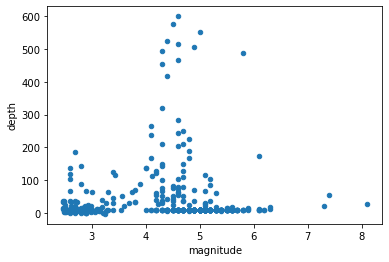

In [11]:
# plot the depth vs. magnitude

df.plot(x='magnitude', y='depth', kind='scatter')

In [12]:
# save the dataframe to disk

df.to_csv('usgs_earthquake_data.csv')

print('file saved')

file saved


In [13]:
# read it back later

new_df = pd.read_csv('usgs_earthquake_data.csv')

print(new_df.head())

   Unnamed: 0  magnitude   depth
0           0        4.7  248.65
1           1        4.9   35.00
2           2        5.1   10.00
3           3        4.6   10.00
4           4        5.0   10.00


# Part 2: Querying an API endpoint

### Google Maps Geocoding API

Google has lots of APIs that let you access its services through code instead of through GUI apps. This one from Google Maps lets you look up the latitude-longitude coordinates of street addresses.

It works similarly to the earthquakes example, but with query parameters added to the URL endpoint!

**API documentation:**  
https://developers.google.com/maps/documentation/geocoding/intro

**API endpoint:**  
https://maps.googleapis.com/maps/api/geocode/json

**API endpoint with query parameters:**  
https://maps.googleapis.com/maps/api/geocode/json?address=Wurster+Hall

In [14]:
import json    # library for working with JSON-formatted text strings
import requests  # library for accessing content from web URLs

import pprint  # library for making Python data structures readable
pp = pprint.PrettyPrinter()

In [15]:
# we have to encode the search query so that it can be passed as a URL, 
# with spaces and other special characters removed

endpoint = 'https://maps.googleapis.com/maps/api/geocode/json'

params = {'address': 'young library uky'}

url = requests.Request('GET', endpoint, params=params).prepare().url
print(url)

https://maps.googleapis.com/maps/api/geocode/json?address=young+library+uky


In [16]:
# download and parse the results

response = requests.get(url)
results = response.text
data = json.loads(results)

print(data)

{'error_message': 'You must use an API key to authenticate each request to Google Maps Platform APIs. For additional information, please refer to http://g.co/dev/maps-no-account', 'results': [], 'status': 'REQUEST_DENIED'}


In [17]:
# print it more nicely

pp.pprint(data)

{'error_message': 'You must use an API key to authenticate each request to '
                  'Google Maps Platform APIs. For additional information, '
                  'please refer to http://g.co/dev/maps-no-account',
 'results': [],
 'status': 'REQUEST_DENIED'}


In [45]:
# pull out the lat-lon coordinates

for r in data['results']:
    coords = r['geometry']['location']
    print(coords['lat'], coords['lng'])

### Exercises

1. Search for some other addresses or landmarks!
2. Take a look at the [API documentation](https://developers.google.com/maps/documentation/geocoding/intro). What are the usage limits?

In [ ]:
# The website linked "http://g.co/dev/maps-no-account" seems to say that there's a $200 monthly fee to use the API for Google Maps
# which is out of my price range so I think I'm going to have to skip this one

In [ ]:
# Contradicting what I said above this website says there is a pay as you go model 
# where "requests for the Geocoding API are billed using the SKU for Geocoding"
# then there is a sliding scale of pricing depending on how many requests you make
# You can only do 50 requests per second (QPS)

# Part 3: Querying an API with authentication

### Twitter REST APIs

Twitter's APIs also operate over the web, but they require a back-and-forth authentication process at the beginning of each connection. It's easier to have a Python library handle this than to create the query URLs ourselves.

The Twitter "REST" APIs perform stand-alone operations: you submit a query and receive results, like in earlier examples. ([REST](https://en.wikipedia.org/wiki/Representational_state_transfer) is a particular set of guidelines that many APIs follow.) Twitter also has a "streaming" API that continues sending results in real time until you disconnect.

**API documentation:**  
https://dev.twitter.com/rest/public  
https://dev.twitter.com/overview/api/tweets

**Documentation for the Python helper library**:  
https://github.com/geduldig/TwitterAPI

In [20]:
from TwitterAPI import TwitterAPI

import pprint  # library for making Python data structures readable
pp = pprint.PrettyPrinter()

In [21]:
# import API credentials from keys.py file in the
# same directory as this notebook

from keys import *

In [22]:
# set up an API connection using credentials from the keys file

api = TwitterAPI(consumer_key, consumer_secret, 
                 access_token, access_token_secret)

print("Connection is set up but not tested")

Connection is set up but not tested


### Making a simple data request

In [23]:
# most recent tweet from @UCBerkeley's timeline

endpoint = 'statuses/user_timeline'
params = {
    'screen_name': 'UKAthletics', 
    'count': 1
}
r = api.request(endpoint, params)

for tweet in r.get_iterator():
    print(tweet['text'])

RT @KentuckyMBB: Last preparations ✅
#SECMBB 🔜


In [24]:
# what other data is there?

pp.pprint(tweet)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Thu Mar 11 04:09:27 +0000 2021',
 'entities': {'hashtags': [{'indices': [37, 44], 'text': 'SECMBB'}],
              'symbols': [],
              'urls': [],
              'user_mentions': [{'id': 35583547,
                                 'id_str': '35583547',
                                 'indices': [3, 15],
                                 'name': 'Kentucky Basketball',
                                 'screen_name': 'KentuckyMBB'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 1369863011234635777,
 'id_str': '1369863011234635777',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 4,
 'retweeted': False,
 'retweeted_status': {'contributors': None,
                      'coordinates': None,
                      '

### Other API endpoints allow different types of searches

In [25]:
# search for public tweets about #BBN

endpoint = 'search/tweets'
params = {
    'q': '#BBN', 
    'count': 5
}
r = api.request(endpoint, params)

for tweet in r.get_iterator():
    print(tweet['text'] + '\n')

RT @rob_akers: UK is 9-15 going into the SEC tournament, same record as Vanderbilt. If the wins and losses were reversed it would still be…

RT @Snow_WRLD: We gotta lock in tomorrow @KentuckyMBB #BBN

RT @KyleNewsomeBBN: This would be a great addition! #BBN https://t.co/j4YUvhujtY

RT @josephstacker2: Kentucky Vs Mississippi State Tomorrow 11:00 AM For Sec Tourney Kentucky Will Win Tomorrow Against Mississippi State in…

RT @DennyArky: #BBN ITS TIME! https://t.co/TEftwENPmB



In [26]:
# search for public tweets in Hindi

endpoint = 'search/tweets'
params = {
    'q': '*', 
    'lang': 'hi', 
    'count': 5
} 
r = api.request(endpoint, params)

for tweet in r.get_iterator():
    print(tweet['text'] + '\n')

@sid_ki_mona @Rupsha_SidHeart Kuch bhi

RT @EramFatima01: कृषि कानून यदि सचमुच में किसानों के फायदे के लिए हैं, तो बंगाल में इस कानून के नाम पर मो'दी वोट क्यों नही मांग रहे?... 🤔🤔

RT @RathodTrivendra: क्या केजरीवाल हिन्दू विरोधी हैं ? #IStandWithManishSingh

RT @actor_nithiin: MAHA SHIVARATRI SHUBHAKANKSHALU.. 

OM NAMAH SHIVAYA 🙏🙏 https://t.co/chlCH0NqHV

RT @IMinakshiJoshi: #Mahashivratri हर हर महादेव 🙏 https://t.co/rb10PWVUKK



In [27]:
# search for public tweets geotagged near the UK campus

endpoint = 'search/tweets'
params = {
    'q': '*', 
    'geocode': '38.034,-84.500,0.5km', 
    'count': 10
} 
r = api.request(endpoint, params)

for tweet in r.get_iterator():
    print(tweet['text'] + '\n')

Who has weed in Lexington,ky

Darty SZN back to full effect!!🍺🍺 #catsby90 #uk Let’s goo been a min @ University of Kentucky https://t.co/IpK8q3Wmsj

Blessings on blessings, still got sum 2 prove...💯 https://t.co/rfrAAGjxNy



### Exercises

1. Try some different search queries!
2. Display some more data fields in addition to the tweet text

In [28]:
endpoint = 'search/tweets'
params = {
    'q': '*', 
    'lang': 'ja', 
    'count': 5
} 
r = api.request(endpoint, params)

for tweet in r.get_iterator():
    print(tweet['text'] + '\n')

彼女は今はいいかな…面倒がかかる弟が2人もいるから

RT @takusikku_star: 少しでも(｡-人-｡) https://t.co/0TmsVeZmFU

RT @baracafe_yuko: #横浜市長林文子
2019年8月22日
この直後、市長室の前にいた。
50人程の市民が2時間あまり待って「会いたくない」と追い返された。
泊まり込み覚悟した💢
あれ以後、市長室前の階段、通行止めになったんだよね。
市民に会いたくない市長って…

死にたい。。。

現物価格 6039887 FX価格 6338420 乖離率 4.942691808638133 予想SFD比率 0



In [41]:
endpoint = 'statuses/user_timeline'
params = {
    'screen_name': 'JStein_WaPo', 
    'count': 5
}
r = api.request(endpoint, params)

for tweet in r.get_iterator():
    print(tweet['text'])

Kudlow on breaking of Gingrich-Clinton consensus on welfare reform and work requirements: “It’s more than fraying —… https://t.co/j8YEaPzxxj
“There’s nothing I can find in here that increases work requirements,” Kudlow says of the relief plan
Kudlow: “doesn’t this blow up the Clinton-Gingrich welfare reform and work requirements?”
Important question not getting enough attention. The shielding of these collections was stripped out of the Biden b… https://t.co/61bsnV7Nwb
Larry Kudlow, now at Fox Business, calls the Biden relief bill “LBJ Great Society to the 100th power”


In [42]:
endpoint = 'statuses/user_timeline'
params = {
    'screen_name': 'Noahpinion', 
    'count': 5
}
r = api.request(endpoint, params)

for tweet in r.get_iterator():
    print(tweet['text'])
    print('Favorited', tweet['favorite_count'])
    print('Retweets', tweet['retweet_count'])

@jdcmedlock https://t.co/AgMR9WdjNW
Favorited 51
Retweets 0
@Aintropy There's evidence it boosts employment fairly durably.
Favorited 3
Retweets 0
I do expect some sort of compromise on the minimum wage. https://t.co/jBHvmo9T0d
Favorited 52
Retweets 2
These days I'm a lot more optimistic that the COVID recession is going to be over quickly. In this post I give seve… https://t.co/QI7pZSF27y
Favorited 21
Retweets 3
@skdh what say you?
Favorited 4
Retweets 1


### Bonus: Streaming live tweets in real time 

In [37]:
# Twitter limits simultaneous connections to the streaming API,
# so this part may not work using the demo API keys during class

endpoint = 'statuses/filter'
params = {'locations': '-180,-90,180,90'}
r = api.request(endpoint, params)
LIMIT = 20

# 'enumerate' lets us count tweets as we receive them

for i, tweet in enumerate(r.get_iterator()):
    print(tweet['created_at'])
    print(tweet['place']['full_name'] + ', ' + tweet['place']['country'])
    print(tweet['text'] + '\n')
    if (i > LIMIT): break

# close the streaming connection
r.close()

Thu Mar 11 04:32:24 +0000 2021
Palo, Eastern Visayas, Republic of the Philippines
Chambe x What Collab when?
Thank you Ms . Alex G

REQUEST @SB19Official @MTV #FridayLivestream 

STREAM SB19WHAT… https://t.co/OZX16euzCs

Thu Mar 11 04:32:24 +0000 2021
大阪 大阪市 阿倍野区, 日本
うん🎵【美韓】ユン・シユンに投票完了！現在の得票数:1047票
ユン・シユン「まだ時間大丈夫？」
人気投票はこちらから↓
 https://t.co/C30jKNMhNl #ユン・シユン #YoonSiYoon #윤시윤 #ユン・シユンからのメッセージ

Thu Mar 11 04:32:24 +0000 2021
Sun Valley, NV, United States
@mannerlymutts @dlowther715 @kylegriffin1 Actually the Trump tax cuts don’t expire until 2025. What do you think ar… https://t.co/TLaUijEeBZ

Thu Mar 11 04:32:24 +0000 2021
Athi River, Kenya, Kenya
@mapule_sechog @KenyanTraffic In Nairobi, you could by now be a personal assistant to the MD

Thu Mar 11 04:32:24 +0000 2021
Nipomo, CA, United States
@_BigBert_1 Lmaoooo, Bert💀💀💀

Thu Mar 11 04:32:25 +0000 2021
Clay, AL, United States
How I’m getting blamed for a fridge I don’t use 🥴🤣😂 whewww chileeee

Thu Mar 11 04:32:25 +0000 2021
Guatemala

### Exercises for the remainder of class

1. Make a scatter plot of the lat-lon coordinates of earthquakes.  
   &nbsp;
   
2. Using the geocoding example as a starting point, try searching the Google Maps Directions API or Elevation API instead. Descriptions are in the [API documentation](https://developers.google.com/maps/documentation/geocoding/intro).  
   &nbsp;
   

In [53]:
d = {'long': [q['geometry']['coordinates'][0] for q in quakes],
     'lat': [q['geometry']['coordinates'][1] for q in quakes]}

df = pd.DataFrame.from_dict(d)

<AxesSubplot:xlabel='long', ylabel='lat'>

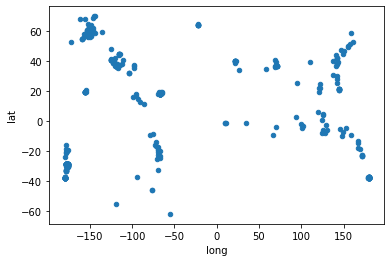

In [55]:
df.plot(x='long', y='lat', kind='scatter')

In [ ]:
## Still don't think I have access to Google's API

### For next time...

In the next class, you will try out another API that provides data you're interested in. You will be asked to try connecting to it using Python code, and performing some basic operations on the data.  To come prepared for next time, please explore some of the transportation-related APIs that may be valuable, and choose one that is of interest to you.

Here are a a few to get you started. 

Public Transit
https://www.programmableweb.com/news/how-smart-cities-are-using-apis-public-transport-apis/2014/05/22

Long-Distance Travel
http://www.olery.com/blog/the-best-travel-apis-discover-contribute/ 

Transportation
https://www.programmableweb.com/category/transportation/api


Start by reading the public transit page, because that provides a nice overview of the types of applications out there, and some of the issues in using them.  These lessons often apply to traffic and transportation more generally.  

Keep in mind that there are a number of different organizations that provide APIs, with different motivations and quality of what is provided.  If it is a private company, what is their business model?  What is the underlying source of the data, and what might that imply about how representative it is of the real world?  There is a ton of stuff out there.  How do we go about sorting out what is useful to us and what is now.  Spend some time exploring these and thinking about these questions.  
